<a href="https://colab.research.google.com/github/Kimgabe/AIFFEL_Online_Quest/blob/main/MainQuest3(%EB%B0%91%EC%8B%9C%EB%94%A5_Final)/%5BMain_Quest03%5D_%EA%B0%80%EC%9C%84%EB%B0%94%EC%9C%84%EB%B3%B4_%EB%B6%84%EB%A5%98%EA%B8%B0_%EB%A7%8C%EB%93%A4%EA%B3%A0_%EC%84%B1%EB%8A%A5%ED%96%A5%EC%83%81%EC%8B%9C%ED%82%A4%EA%B8%B0(%EC%9D%B4%EB%AF%B8%EC%A7%80%EC%97%90%EB%9F%AC%20%EC%88%98%EC%A0%95ver%20%EC%9E%AC%EC%97%85%EB%A1%9C%EB%93%9C).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📌 Intro.
- AIFFEL Core과정 7기의 3번째 메인 퀘스트인 '쫄지말자 딥러닝' 노드의 메인 퀘스트를 수행합니다.
- 밑바닥부터 배우는 딥러닝 책을 함께 공부하면서 기본적인 딥러닝의 방법과 기본적 이론, 작동 원리를 공부했습니다.
- 오늘은 이를 활용한 다중분류기를 구현하고 응용하는 프로젝트를 진행합니다.
- 특히, 이전에 MNIST를 활용한 손글씨 분류기 모델을 만들고 성능을 높이는 하이퍼파라미터 튜닝을 진행했으므로 이를 응용해서 가위, 바위, 보 분류기를 만들어 보도록 하겠습니다.

---

- 특히, 이번 프로젝트에서는 실제로 이미지 데이터를 수집하여 구현하는 과정까지 포함해 수행해보도록 하겠습니다.

In [ ]:
# 사용할 라이브러리 버전 확인
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.13.0
1.24.3


# 데이터 수집
- 가위, 바위, 보 분류기 생성을 위한 데이터 수집을 해야 합니다.
- 통상적으로 CNN모델을 훈련하기 위해서는 최소 500장~1000장 정도의 이미지가 필요하다고 합니다.
- 구글의 [Teachable Machine](https://teachablemachine.withgoogle.com/)은 이러한 작업을 손쉽게 할 수 있는 서비스를 제공합니다.

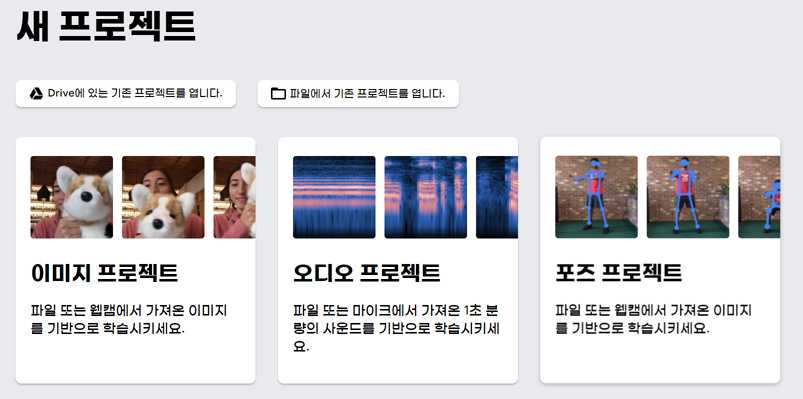

- 위 이미지 같이 다양한 종류의 프로젝트를 위한 데이터 생성을 지원하며, 노트북의 웹캠과 연동하여 손쉽게 데이터 생성이 가능합니다.
- 버튼을 누르고 있으면 핸드폰 카메라의 연사처럼 여러개의 사진이 지속적으로 촬영됩니다.



- 실제로는 수집한 데이터로 모델 학습및 결과 확인까지 가능하지만, 데이터만을 다운받아서 모델을 직접 구축해보도록 하겠습니다.
- 수집한 샘플은 각각 `Scissors.zip`, `Rock.zip`, `Paper.zip` 으로 되어 있습니다.
- 로컬에서 모델을 생성할 것이므로 이를 `data` 폴더에 옮겨서 모델을 구축하도록 하겠습니다.

## 데이터 불러오기 및 데이터셋 구축

- 일단 현재 데이터가 있는 디렉토리는 구조는 아래와 같습니다.

```python
data
└── rock_scissor_paper
    ├── rock
        └── rock.zip
    ├── scissor
        └── scissor.zip
    └── paper
        └── paper.zip
```

- scissor.zip 에서 가위 이미지 한개를 불러와서 shape를 확인해 보겠습니다.

### 생성데이터 압축 풀기

In [ ]:
import os
import zipfile

def unzip_files(base_path):
    # 각 폴더 이름 (scissor, rock, paper)
    folders = ['scissor', 'rock', 'paper']

    for folder in folders:
        # 폴더 내의 모든 파일 중 .zip 파일을 제외하고 삭제
        folder_path = os.path.join(base_path, folder)
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            if not filename.endswith('.zip') and os.path.isfile(file_path):
                os.remove(file_path)
                # print(f"{filename} 삭제 완료")

        # .zip 파일 경로
        zip_file_path = os.path.join(base_path, folder, folder + '.zip')

        # Zip 파일이 존재하는 경우 압축 해제
        if os.path.exists(zip_file_path):
            with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
                zip_ref.extractall(os.path.join(base_path, folder))
            print(folder + " 압축 해제 완료")
        else:
            print(zip_file_path + " 파일을 찾을 수 없습니다.")


base_path = '../data/rock_scissor_paper'
unzip_files(base_path)

scissor 압축 해제 완료
rock 압축 해제 완료
paper 압축 해제 완료


### 각 폴더별로 데이터 불러오기

In [ ]:
import os

# 데이터 폴더 경로 설정
data_folder = "../data/rock_scissor_paper"

# 폴더 이름 리스트
folder_names = ["scissor", "rock", "paper"]

# 각 폴더에서 확장자가 '.jpg'인 파일 개수 확인
data = {}  # 데이터 개수를 저장할 딕셔너리

for folder_name in folder_names:
    folder_path = os.path.join(data_folder, folder_name)
    file_list = [f for f in os.listdir(folder_path) if f.endswith(".jpg")]
    data[folder_name] = len(file_list)  # 파일 개수를 저장

# 결과 출력
print("scissor 폴더에 있는 .jpg 파일 개수:", data["scissor"])
print("rock 폴더에 있는 .jpg 파일 개수:", data["rock"])
print("paper 폴더에 있는 .jpg 파일 개수:", data["paper"])

scissor 폴더에 있는 .jpg 파일 개수: 100
rock 폴더에 있는 .jpg 파일 개수: 100
paper 폴더에 있는 .jpg 파일 개수: 100


In [ ]:
from PIL import Image
import glob

# 이미지 파일이 저장된 폴더 경로 설정
image_folder = "../data/rock_scissor_paper/scissor"  # 확인하고자 하는 폴더 선택

# 폴더 내의 이미지 파일 목록 가져오기
image_files = glob.glob(os.path.join(image_folder, "*.jpg"))

# 이미지 파일 중 하나 선택하여 모양(shape) 확인
if image_files:
    # 첫 번째 이미지 선택
    image_path = image_files[0]

    # 이미지 열기
    img = Image.open(image_path)

    # 이미지의 모양(shape) 확인
    image_shape = img.size  # 이미지의 가로(width)와 세로(height)

    # 결과 출력
    print(f"Scissor의 0번째 이미지의 모양(shape): {image_shape}")
else:
    print("폴더에 이미지 파일이 없습니다.")

Scissor의 0번째 이미지의 모양(shape): (224, 224)


- 손글씨 모델에서 사용한 데이터는 (28,28) 형태의 데이터였지만, 지금은 (224,224) 형태의 데이터 입니다.
- zip파일 안에 있는 데이터같은 shape의 데이터로 변경하도록 하겠습니다.

In [ ]:
def resize_images(img_path):
    images = glob.glob(img_path + "/*.jpg")
    print(len(images), "개의 이미지가 리사이즈될 예정입니다.")

    # 각 파일을 지정된 크기로 변경
    target_size = (28, 28)
    for img in images:
        old_img = Image.open(img)
        new_img = old_img.resize(target_size)  # Image.ANTIALIAS 제거
        new_img.save(img, "JPEG")

    print(len(images), "개의 이미지가 리사이즈되었습니다.")

image_dir_paths = [
    "../data/rock_scissor_paper/scissor",
    "../data/rock_scissor_paper/rock",
    "../data/rock_scissor_paper/paper"
]

for path in image_dir_paths:
    resize_images(path)
    if path.endswith("/scissor"):
        print("-" * 30)  # 30개의 '-'로 이루어진 경계선
        print("가위 이미지 리사이즈 완료!")
        print("-" * 30)  # 경계선 다시 출력
    elif path.endswith("/rock"):
        print("-" * 30)
        print("바위 이미지 리사이즈 완료!")
        print("-" * 30)
    elif path.endswith("/paper"):
        print("-" * 30)
        print("보 이미지 리사이즈 완료!")
        print("-" * 30)

100 개의 이미지가 리사이즈될 예정입니다.
100 개의 이미지가 리사이즈되었습니다.
------------------------------
가위 이미지 리사이즈 완료!
------------------------------
100 개의 이미지가 리사이즈될 예정입니다.
100 개의 이미지가 리사이즈되었습니다.
------------------------------
바위 이미지 리사이즈 완료!
------------------------------
100 개의 이미지가 리사이즈될 예정입니다.
100 개의 이미지가 리사이즈되었습니다.
------------------------------
보 이미지 리사이즈 완료!
------------------------------


In [ ]:
import numpy as np

def load_data(img_path, number_of_data, dataset_type="Training"):
    img_size = 28
    color = 3
    imgs = np.zeros(number_of_data * img_size * img_size * color, dtype=np.int32).reshape(number_of_data, img_size, img_size, color)
    labels = np.zeros(number_of_data, dtype=np.int32)

    idx = 0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        if idx >= number_of_data:
            break
        img = np.array(Image.open(file), dtype=np.int32)
        imgs[idx,:,:,:] = img
        labels[idx] = 0
        idx += 1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        if idx >= number_of_data:
            break
        img = np.array(Image.open(file), dtype=np.int32)
        imgs[idx,:,:,:] = img
        labels[idx] = 1
        idx += 1

    for file in glob.iglob(img_path+'/paper/*.jpg'):
        if idx >= number_of_data:
            break
        img = np.array(Image.open(file), dtype=np.int32)
        imgs[idx,:,:,:] = img
        labels[idx] = 2
        idx += 1

    print(dataset_type + " 데이터의 로드된 이미지 수: ", idx)
    return imgs, labels

# 학습 데이터 세트 로드
image_dir_path = "../data/rock_scissor_paper"
(x_train, y_train) = load_data(image_dir_path, number_of_data = 300, dataset_type="학습")
x_train = x_train[:300]
x_train_norm = x_train / 255.0 # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습 데이터의 로드된 이미지 수:  300
x_train shape: (300, 28, 28, 3)
y_train shape: (300,)


라벨:  0


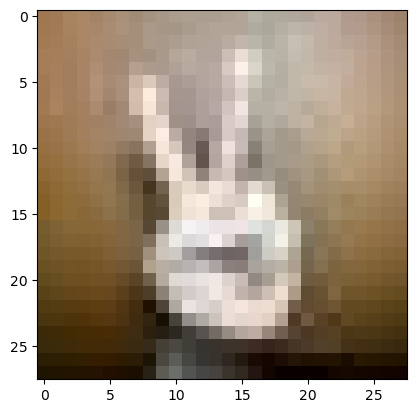

In [ ]:
# 변형된 데이터 불러와서 확인하기

import matplotlib.pyplot as plt

plt.imshow(x_train[0])
print('라벨: ', y_train[0])

# 딥러닝 네트워크 설계하기

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# 이미지 채널이 3개로 바뀌었고, 추론할 클래스도 3개로 변했음

# 모델 생성
model = keras.models.Sequential()

# 첫 번째 컨볼루션 층 추가
model.add(keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 3)))

# 첫 번째 맥스 풀링 층 추가
model.add(keras.layers.MaxPooling2D(2, 2))

# 두 번째 컨볼루션 층 추가
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))

# 두 번째 맥스 풀링 층 추가
model.add(keras.layers.MaxPooling2D(2, 2))

# 데이터 평탄화 층 추가
model.add(keras.layers.Flatten())

# 완전 연결 (Dense) 층 추가
model.add(keras.layers.Dense(64, activation='relu'))

# 출력 층 추가 (클래스가 3개임을 고려)
model.add(keras.layers.Dense(3, activation='softmax'))

# 모델 요약 출력
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 64)                5

## 딥러닝 네트워크 학습시키기

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 학습
history = model.fit(x_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
8/8 [==============================] - 1s 25ms/step - loss: 20.6018 - accuracy: 0.3667 - val_loss: 45.4960 - val_accuracy: 0.0000e+00
Epoch 2/10
8/8 [==============================] - 0s 9ms/step - loss: 4.1258 - accuracy: 0.7250 - val_loss: 2.6323 - val_accuracy: 0.6167
Epoch 3/10
8/8 [==============================] - 0s 8ms/step - loss: 0.8270 - accuracy: 0.8750 - val_loss: 6.3678 - val_accuracy: 0.2667
Epoch 4/10
8/8 [==============================] - 0s 9ms/step - loss: 0.0954 - accuracy: 0.9750 - val_loss: 0.1338 - val_accuracy: 0.9167
Epoch 5/10
8/8 [==============================] - 0s 9ms/step - loss: 0.0161 - accuracy: 0.9958 - val_loss: 1.5003 - val_accuracy: 0.7333
Epoch 6/10
8/8 [==============================] - 0s 9ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 3.8718 - val_accuracy: 0.4833
Epoch 7/10
8/8 [==============================] - 0s 9ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 1.0869 - val_accuracy: 0.7500
Epoch 8/10
8/8 [===========

# 학습결과 테스트하기

## 테스트데이터 불러오기 및 생성

- 같은 퀘스트를 진행하는 동료그루들이 생성한 데이터를 공유받아 테스트용 데이터로 사용했습니다.
- 학습데이터와 동일하게 rock, scissor, paper 각각 100장씩 총 300장의 데이터를 사용했습니다.

In [ ]:
# 테스트 데이터 리사이징
image_dir_paths = [
    "../data/rock_scissor_paper/test/scissor",
    "../data/rock_scissor_paper/test/rock",
    "../data/rock_scissor_paper/test/paper"
]

for path in image_dir_paths:
    resize_images(path)
    if path.endswith("/scissor"):
        print("-" * 30)  # 30개의 '-'로 이루어진 경계선
        print("가위(테스트) 이미지 리사이즈 완료!")
        print("-" * 30)  # 경계선 다시 출력
    elif path.endswith("/rock"):
        print("-" * 30)
        print("바위(테스트) 이미지 리사이즈 완료!")
        print("-" * 30)
    elif path.endswith("/paper"):
        print("-" * 30)
        print("보(테스트) 이미지 리사이즈 완료!")
        print("-" * 30)

100 개의 이미지가 리사이즈될 예정입니다.
100 개의 이미지가 리사이즈되었습니다.
------------------------------
가위(테스트) 이미지 리사이즈 완료!
------------------------------
100 개의 이미지가 리사이즈될 예정입니다.
100 개의 이미지가 리사이즈되었습니다.
------------------------------
바위(테스트) 이미지 리사이즈 완료!
------------------------------
100 개의 이미지가 리사이즈될 예정입니다.
100 개의 이미지가 리사이즈되었습니다.
------------------------------
보(테스트) 이미지 리사이즈 완료!
------------------------------


In [ ]:
# 테스트 데이터 세트 로드
image_dir_path = "../data/rock_scissor_paper/test"
(x_test, y_test) = load_data(image_dir_path, 300, dataset_type="테스트")
x_test = x_test[:300]

x_test_norm = x_test / 255.0 # 입력은 0~1 사이의 값으로 정규화

print("x_test의 형태: {}".format(x_test.shape))
print("y_test의 형태: {}".format(y_test.shape))

테스트 데이터의 로드된 이미지 수:  300
x_test의 형태: (300, 28, 28, 3)
y_test의 형태: (300,)


## 테스트 결과 확인

In [ ]:
# x_test_reshaped는 테스트 데이터이고, y_test는 데이터의 실제 레이블입니다
# verbose=2는 평가 과정을 자세히 표시합니다
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)

# 테스트 손실(test_loss)과 테스트 정확도(test_accuracy)를 출력합니다
print(f"테스트 손실: {test_loss}")
print(f"테스트 정확도: {test_accuracy}")

10/10 - 0s - loss: 6.3252 - accuracy: 0.3933 - 41ms/epoch - 4ms/step
테스트 손실: 6.3251633644104
테스트 정확도: 0.3933333456516266


### 테스트 결과 해석

- 테스트 손실
    - 테스트 데이터에 대한 손실값은 42.4763입니다.
    - 손실값이 높을 수록 모델의 예측이 실제 레이블과 더 멀어짐을 의미합니다.
    - 일반적으로 낮은 손실값이 더 좋은 모델 성능을 나타냅니다.
- 테스트 정확도
    - 모델정확도는 약 33.33%로 매우 낮습니다.
    - 이는 모델의 클래스가 3개인점을 고려하면 최소한의 성능만이 구현된 듯합니다.

## 잘못 추론한 데이터 확인하기

### 모델이 올바르게 추정한 데이터의 확률 살펴보기

In [ ]:
# 모델을 사용하여 테스트 데이터에 대한 예측을 수행
# 모델이 각 클래스(숫자)에 대한 확률 값을 출력
predicted_result = model.predict(x_test)  # 모델에 의해 추정된 확률 값

# 각 테스트 데이터에 대한 예측된 클래스 레이블을 계산, argmax 함수를 사용하여 가장 높은 확률 값을 갖는 클래스를 선택
predicted_labels = np.argmax(predicted_result, axis=1)

# 분석할 테스트 데이터의 인덱스를 선택(첫 번째 데이터를 선택)
idx = 0

# 모델의 예측 결과를 출력.
# predicted_result[idx]는 해당 데이터에 대한 클래스별 확률 값을 의미
# 본래는 벡터 형태로 나오지만 직관적으로 보기 위해 확률값으로 변환
# print('model.predict() 결과: ', predicted_result[idx]) # 벡터값 출력 예시

# 모델의 예측 결과를 확률로 변환하여 출력
predicted_probabilities = tf.nn.softmax(predicted_result[idx])

# 각 클래스(숫자)에 대한 확률 값을 출력
print('모델이 예측한 확률 값: ', predicted_probabilities.numpy()) # nupy() 로 텐서를 numpy 배열로 변경

# 모델이 가장 높은 확률을 갖는 클래스를 선택하여 출력(모델이 예측한 클래스 레이블)
print('모델이 가장 가능성 있는 결과로 추론한 값: ', predicted_labels[idx])

# 실제 데이터의 레이블을 출력(테스트 데이터의 실제 클래스 레이블)
print('실제 데이터의 레이블: ', y_test[idx])

10/10 [==============================] - 0s 2ms/step
모델이 예측한 확률 값:  [0.23557353 0.2176838  0.5467427 ]
모델이 가장 가능성 있는 결과로 추론한 값:  2
실제 데이터의 레이블:  0


### 잘못 추정한 데이터 살펴보기

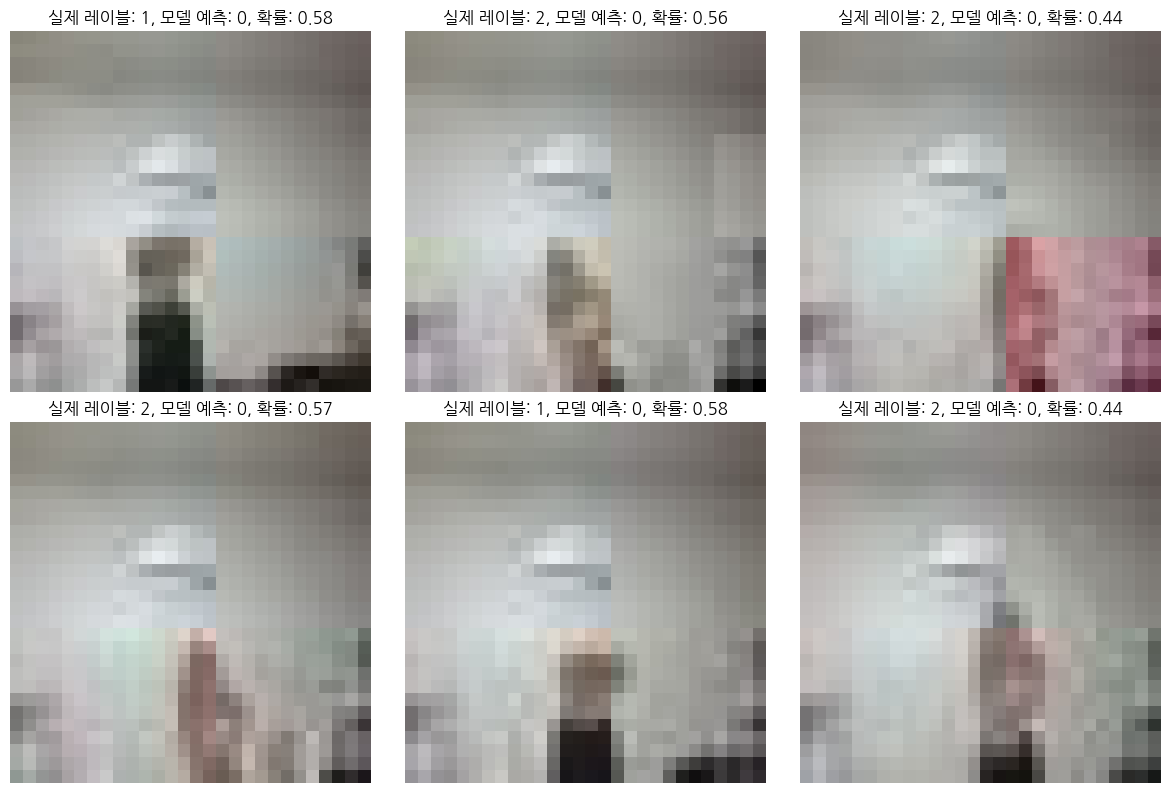

In [ ]:
import random
import koreanize_matplotlib


# 잘못 예측된 경우의 인덱스를 저장할 리스트 초기화
wrong_predict_list = []

# 모든 예측 결과를 반복하며 실제 레이블과 다른 경우에만 인덱스 저장
for i, _ in enumerate(predicted_labels):
    if predicted_labels[i] != y_test[i]:
        wrong_predict_list.append(i)

# 잘못 예측된 경우 중에서 6개를 무작위로 선택
sample = random.choices(population=wrong_predict_list, k=6)

# 2행 3열의 서브플롯 생성
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, n in enumerate(sample):
    # 서브플롯의 행과 열 계산
    row = i // 3
    col = i % 3

    # 모델이 예측한 확률 분포 계산
    predicted_probabilities = tf.nn.softmax(predicted_result[n]).numpy()

    # 실제 레이블과 모델 예측 결과 및 확률값 출력
    label_and_prediction = "실제 레이블: {}, 모델 예측: {}, 확률: {:.2f}".format(
        y_test[n], predicted_labels[n], max(predicted_probabilities))

    # 잘못 예측된 이미지 그리기
    axes[row, col].imshow(x_test[n], cmap=plt.cm.binary)
    axes[row, col].set_title(label_and_prediction)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

- 3개의 클래스에 대해 예측하는 모델이기 때문에 아무리 모델 학습이 잘 되지 않아도 평균적으로 33%정도의 정확도는 나올 것으로 기대했는데, 최종적인 모델의 정확도는 30% 이하로 아주 성능이 좋지 못한 모델이 만들어 졌습니다.
- 여러 이유가 있을 수 있으나 가장 먼저 걱정이 되는것은 학습데이터와 테스트 데이터의 특징이 많이 다른 것 같습니다.

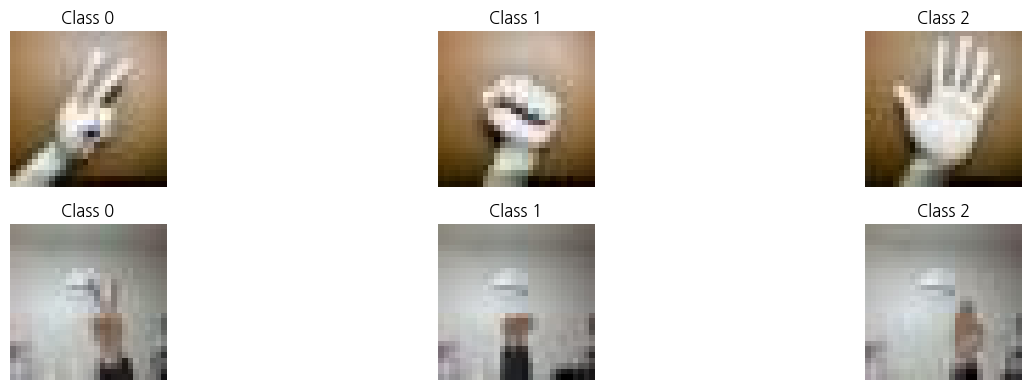

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# 클래스별로 데이터 인덱스를 추출하는 함수
def extract_class_samples(x, y, num_classes):
    class_indices = {}
    for class_idx in range(num_classes):
        class_indices[class_idx] = [i for i, label in enumerate(y) if label == class_idx]
    return class_indices

# 각 클래스별 하나의 샘플을 무작위로 선택하는 함수
def choose_random_samples(class_indices, num_classes):
    sample_indices = []
    for class_idx in range(num_classes):
        sample_indices.append(random.choice(class_indices[class_idx]))
    return sample_indices

# 학습 및 테스트 데이터에서 클래스별로 샘플 선택
num_classes = len(np.unique(y_train)) # 클래스의 개수를 결정
train_class_indices = extract_class_samples(x_train, y_train, num_classes)
test_class_indices = extract_class_samples(x_test, y_test, num_classes)

# 무작위로 학습 및 테스트 샘플 선택
train_samples = choose_random_samples(train_class_indices, num_classes)
test_samples = choose_random_samples(test_class_indices, num_classes)

# 이미지 데이터를 올바른 형식으로 로드 및 변환
x_train = np.array(x_train)  # 이미지 데이터를 numpy 배열로 변환
x_test = np.array(x_test)    # 이미지 데이터를 numpy 배열로 변환

# 시각화
fig, axes = plt.subplots(2, num_classes, figsize=(15, 4))

for i, idx in enumerate(train_samples):
    axes[0, i].imshow(x_train[idx], cmap=plt.cm.binary)
    axes[0, i].set_title(f'Class {y_train[idx]}')
    axes[0, i].axis('off')

for i, idx in enumerate(test_samples):
    axes[1, i].imshow(x_test[idx], cmap=plt.cm.binary)
    axes[1, i].set_title(f'Class {y_test[idx]}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

- 따라서 학습 데이터의 볼륨을 늘려서 재학습을 진행해보도록 하겠습니다.
- 그 외 다른 모델 성능 개선방안들을 다양하게 시도해보도록 하겠습니다.

# 모델 성능 개선하기

- 모델 성능 개선을 위해 사용할 수 있는 방법이 다양하게 있음을 공부하며 배웠습니다.
- 이번 과정에서는 **모델 성능의 획기적인 향상보다는 공부했던 다양한 기법들을 최대한 적용해보는 것을 목표**로 모델 성능 개선을 시도하겠습니다.
- 시도할 모델 성능 개선 방법은 아래와 같습니다.

1. 학습데이터 추가
2. 학습률 조정
3. 드롭아웃
4. 학습률 조정
5. 데이터 증강(Data Augmentation)
6. 베이지안 최적화(Baysian Optimization)

---

## 1. 학습 데이터 추가

- 추가적인 학습데이터는 같은 기수에 학습하고 있는 그루분들이 생성한 데이터를 활용하도록 하겠습니다.
- 유사한 task를 수행한 문서를 찾아보니 약 730여개의 이미지를 활용한 것을 확인했습니다.[(참고문헌)](https://medium.com/geekculture/rock-paper-scissors-image-classification-using-cnn-eefe4569b415)
    - 데이터셋의 구성만 참고했고, 내용을 보진 않았습니다. (퀘스트 종료후에 살펴볼 예정입니다.)
- 이를 고려해 동료 그루 2분의 데이터 600개를 추가해 총 900개의 데이터로 모델을 재학습 하겠습니다

---

- 추가데이터는 구글드라이브에서 다운받아 로컬 폴더에 입력하는데, 모든 파일명들이 `0.jpg` 와 같이 폴더로만 데이터가 구분되고 파일명에선 구분이 되지 않습니다.
- 동일한 파일명에 대해 `0(1).jpg`, `0(2).jpg` 와 같은 식으로 파일명이 생성될 것이기 때문에 이를 정리하기위한 함수를 하나 생성해 적용하겠습니다.

In [ ]:
# 추가 데이터 1 unzip
base_path = '../data/rock_scissor_paper/additional_1'
unzip_files(base_path)

# 추가 데이터 2 unzip
base_path = '../data/rock_scissor_paper/additional_2'
unzip_files(base_path)

# 추가 데이터 3 unzip
base_path = '../data/rock_scissor_paper/additional_3'
unzip_files(base_path)

# 추가 데이터 3 unzip
base_path = '../data/rock_scissor_paper/additional_4'
unzip_files(base_path)

# 추가 데이터 5 unzip
base_path = '../data/rock_scissor_paper/additional_5'
unzip_files(base_path)

# 추가 데이터 6 unzip
base_path = '../data/rock_scissor_paper/additional_6'
unzip_files(base_path)

# 추가 데이터 7 unzip
base_path = '../data/rock_scissor_paper/additional_7'
unzip_files(base_path)

# 추가 데이터 8 unzip
base_path = '../data/rock_scissor_paper/additional_8'
unzip_files(base_path)

scissor 압축 해제 완료
rock 압축 해제 완료
paper 압축 해제 완료
scissor 압축 해제 완료
rock 압축 해제 완료
paper 압축 해제 완료
scissor 압축 해제 완료
rock 압축 해제 완료
paper 압축 해제 완료
scissor 압축 해제 완료
rock 압축 해제 완료
paper 압축 해제 완료
scissor 압축 해제 완료
rock 압축 해제 완료
paper 압축 해제 완료
scissor 압축 해제 완료
rock 압축 해제 완료
paper 압축 해제 완료
scissor 압축 해제 완료
rock 압축 해제 완료
paper 압축 해제 완료
scissor 압축 해제 완료
rock 압축 해제 완료
paper 압축 해제 완료


In [ ]:
def rename_and_move_files(folders_dict):
    for category in ['rock', 'scissor', 'paper']:
        src_folder = os.path.join(folders_dict['src'], category)
        dest_folder = os.path.join(folders_dict['dest'], category)

        # 1번째 폴더에서 가장 큰 숫자 찾기
        max_num = 0
        for file in os.listdir(src_folder):
            if file.endswith('.jpg'):
                num = int(file.split('.')[0])
                max_num = max(max_num, num)

        # 2번째 폴더의 파일 이름 변경 및 이동
        next_num = max_num + 1
        completed = True  # 폴더별로 완료 여부를 추적하기 위한 변수

        for file in os.listdir(dest_folder):
            if file.endswith('.jpg'):
                old_name = file
                new_name = f"{next_num}.jpg"
                new_path = os.path.join(src_folder, new_name)
                old_path = os.path.join(dest_folder, old_name)

                try:
                    # 파일 이름 변경
                    os.rename(old_path, new_path)
                    #print(f"{old_name}을(를) {new_name}로 변경 및 이동")
                except Exception as e:
                    print(f"오류 발생: {e}")
                    completed = False  # 오류 발생 시 완료 여부를 False로 설정

                next_num += 1

        if completed:
            print(f"{category} 카테고리의 파일 이름 변경 및 이동이 완료되었습니다.")


# 반복할 폴더 목록을 만듭니다.
src_folder = '../data/rock_scissor_paper/'
dest_folders = ['additional_1', 'additional_2', 'additional_3', 'additional_4', 'additional_5', 'additional_6', 'additional_7', 'additional_8']

# 각 dest 폴더에 대해 작업을 수행하는 반복문을 만듭니다.
for dest_folder_name in dest_folders:
    # 슬래시로 경로를 지정합니다.
    dest_path = os.path.join(src_folder, dest_folder_name)

    # 실제로 파일을 이동하거나 작업을 수행하는 함수 호출
    folders_dict = {'src': src_folder, 'dest': dest_path}
    rename_and_move_files(folders_dict)

rock 카테고리의 파일 이름 변경 및 이동이 완료되었습니다.
scissor 카테고리의 파일 이름 변경 및 이동이 완료되었습니다.
paper 카테고리의 파일 이름 변경 및 이동이 완료되었습니다.
rock 카테고리의 파일 이름 변경 및 이동이 완료되었습니다.
scissor 카테고리의 파일 이름 변경 및 이동이 완료되었습니다.
paper 카테고리의 파일 이름 변경 및 이동이 완료되었습니다.
rock 카테고리의 파일 이름 변경 및 이동이 완료되었습니다.
scissor 카테고리의 파일 이름 변경 및 이동이 완료되었습니다.
paper 카테고리의 파일 이름 변경 및 이동이 완료되었습니다.
rock 카테고리의 파일 이름 변경 및 이동이 완료되었습니다.
scissor 카테고리의 파일 이름 변경 및 이동이 완료되었습니다.
paper 카테고리의 파일 이름 변경 및 이동이 완료되었습니다.
rock 카테고리의 파일 이름 변경 및 이동이 완료되었습니다.
scissor 카테고리의 파일 이름 변경 및 이동이 완료되었습니다.
paper 카테고리의 파일 이름 변경 및 이동이 완료되었습니다.
rock 카테고리의 파일 이름 변경 및 이동이 완료되었습니다.
scissor 카테고리의 파일 이름 변경 및 이동이 완료되었습니다.
paper 카테고리의 파일 이름 변경 및 이동이 완료되었습니다.
rock 카테고리의 파일 이름 변경 및 이동이 완료되었습니다.
scissor 카테고리의 파일 이름 변경 및 이동이 완료되었습니다.
paper 카테고리의 파일 이름 변경 및 이동이 완료되었습니다.
rock 카테고리의 파일 이름 변경 및 이동이 완료되었습니다.
scissor 카테고리의 파일 이름 변경 및 이동이 완료되었습니다.
paper 카테고리의 파일 이름 변경 및 이동이 완료되었습니다.


### 이미지 리사이징

In [ ]:
def resize_images(img_path):
    images = glob.glob(img_path + "/*.jpg")
    print(f"{len(images)}개의 이미지가 검사됩니다.")

    target_size = (28, 28)
    resized_count = 0

    for img in images:
        with Image.open(img) as old_img:
            if old_img.size != target_size:
                new_img = old_img.resize(target_size)
                new_img.save(img, "JPEG")
                resized_count += 1
                print(f"{img} 리사이즈됨")
            else:
                print(f"{img} 이미지는 이미 크기가 (28, 28)이므로 패스합니다.")
                pass

    print(f"{resized_count}개의 이미지가 리사이즈되었습니다.")


# 작업 경로
image_dir_paths = [
    "../data/rock_scissor_paper/scissor",
    "../data/rock_scissor_paper/rock",
    "../data/rock_scissor_paper/paper"
]

for path in image_dir_paths:
    resize_images(path)
    if path.endswith("/scissor"):
        print("-" * 30)
        print("가위 이미지 리사이즈 완료!")
        print("-" * 30)
    elif path.endswith("/rock"):
        print("-" * 30)
        print("바위 이미지 리사이즈 완료!")
        print("-" * 30)
    elif path.endswith("/paper"):
        print("-" * 30)
        print("보 이미지 리사이즈 완료!")
        print("-" * 30)

1135개의 이미지가 검사됩니다.
../data/rock_scissor_paper/scissor\0.jpg 이미지는 이미 크기가 (28, 28)이므로 패스합니다.
../data/rock_scissor_paper/scissor\1.jpg 이미지는 이미 크기가 (28, 28)이므로 패스합니다.
../data/rock_scissor_paper/scissor\10.jpg 이미지는 이미 크기가 (28, 28)이므로 패스합니다.
../data/rock_scissor_paper/scissor\100.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\1000.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\1001.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\1002.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\1003.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\1004.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\1005.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\1006.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\1007.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\1008.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\1009.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\101.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\1010.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\1011.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\1012.jpg 리사이즈됨
../data/rock_sci

../data/rock_scissor_paper/scissor\133.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\134.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\135.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\136.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\137.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\138.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\139.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\14.jpg 이미지는 이미 크기가 (28, 28)이므로 패스합니다.
../data/rock_scissor_paper/scissor\140.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\141.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\142.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\143.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\144.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\145.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\146.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\147.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\148.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\149.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\15.jpg 이미지는 이미 크기가 (28, 28)이므로 패스합니다.
../data/rock_scissor_

../data/rock_scissor_paper/scissor\280.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\281.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\282.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\283.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\284.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\285.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\286.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\287.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\288.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\289.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\29.jpg 이미지는 이미 크기가 (28, 28)이므로 패스합니다.
../data/rock_scissor_paper/scissor\290.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\291.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\292.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\293.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\294.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\295.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\296.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\297.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\298.jpg 리사

../data/rock_scissor_paper/scissor\430.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\431.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\432.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\433.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\434.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\435.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\436.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\437.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\438.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\439.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\44.jpg 이미지는 이미 크기가 (28, 28)이므로 패스합니다.
../data/rock_scissor_paper/scissor\440.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\441.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\442.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\443.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\444.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\445.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\446.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\447.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\448.jpg 리사

../data/rock_scissor_paper/scissor\622.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\623.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\624.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\625.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\626.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\627.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\628.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\629.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\63.jpg 이미지는 이미 크기가 (28, 28)이므로 패스합니다.
../data/rock_scissor_paper/scissor\630.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\631.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\632.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\633.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\634.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\635.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\636.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\637.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\638.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\639.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\64.jpg 이미지

../data/rock_scissor_paper/scissor\769.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\77.jpg 이미지는 이미 크기가 (28, 28)이므로 패스합니다.
../data/rock_scissor_paper/scissor\770.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\771.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\772.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\773.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\774.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\775.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\776.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\777.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\778.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\779.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\78.jpg 이미지는 이미 크기가 (28, 28)이므로 패스합니다.
../data/rock_scissor_paper/scissor\780.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\781.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\782.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\783.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\784.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\785.jpg 리사이즈됨
../data/rock_scissor_

../data/rock_scissor_paper/scissor\959.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\96.jpg 이미지는 이미 크기가 (28, 28)이므로 패스합니다.
../data/rock_scissor_paper/scissor\960.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\961.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\962.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\963.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\964.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\965.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\966.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\967.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\968.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\969.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\97.jpg 이미지는 이미 크기가 (28, 28)이므로 패스합니다.
../data/rock_scissor_paper/scissor\970.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\971.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\972.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\973.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\974.jpg 리사이즈됨
../data/rock_scissor_paper/scissor\975.jpg 리사이즈됨
../data/rock_scissor_

../data/rock_scissor_paper/rock\1137.jpg 리사이즈됨
../data/rock_scissor_paper/rock\1138.jpg 리사이즈됨
../data/rock_scissor_paper/rock\1139.jpg 리사이즈됨
../data/rock_scissor_paper/rock\114.jpg 리사이즈됨
../data/rock_scissor_paper/rock\1140.jpg 리사이즈됨
../data/rock_scissor_paper/rock\1141.jpg 리사이즈됨
../data/rock_scissor_paper/rock\1142.jpg 리사이즈됨
../data/rock_scissor_paper/rock\1143.jpg 리사이즈됨
../data/rock_scissor_paper/rock\1144.jpg 리사이즈됨
../data/rock_scissor_paper/rock\1145.jpg 리사이즈됨
../data/rock_scissor_paper/rock\1146.jpg 리사이즈됨
../data/rock_scissor_paper/rock\1147.jpg 리사이즈됨
../data/rock_scissor_paper/rock\1148.jpg 리사이즈됨
../data/rock_scissor_paper/rock\1149.jpg 리사이즈됨
../data/rock_scissor_paper/rock\115.jpg 리사이즈됨
../data/rock_scissor_paper/rock\1150.jpg 리사이즈됨
../data/rock_scissor_paper/rock\1151.jpg 리사이즈됨
../data/rock_scissor_paper/rock\1152.jpg 리사이즈됨
../data/rock_scissor_paper/rock\1153.jpg 리사이즈됨
../data/rock_scissor_paper/rock\1154.jpg 리사이즈됨
../data/rock_scissor_paper/rock\1155.jpg 리사이즈됨
../data/rock_sc

../data/rock_scissor_paper/rock\257.jpg 리사이즈됨
../data/rock_scissor_paper/rock\258.jpg 리사이즈됨
../data/rock_scissor_paper/rock\259.jpg 리사이즈됨
../data/rock_scissor_paper/rock\26.jpg 이미지는 이미 크기가 (28, 28)이므로 패스합니다.
../data/rock_scissor_paper/rock\260.jpg 리사이즈됨
../data/rock_scissor_paper/rock\261.jpg 리사이즈됨
../data/rock_scissor_paper/rock\262.jpg 리사이즈됨
../data/rock_scissor_paper/rock\263.jpg 리사이즈됨
../data/rock_scissor_paper/rock\264.jpg 리사이즈됨
../data/rock_scissor_paper/rock\265.jpg 리사이즈됨
../data/rock_scissor_paper/rock\266.jpg 리사이즈됨
../data/rock_scissor_paper/rock\267.jpg 리사이즈됨
../data/rock_scissor_paper/rock\268.jpg 리사이즈됨
../data/rock_scissor_paper/rock\269.jpg 리사이즈됨
../data/rock_scissor_paper/rock\27.jpg 이미지는 이미 크기가 (28, 28)이므로 패스합니다.
../data/rock_scissor_paper/rock\270.jpg 리사이즈됨
../data/rock_scissor_paper/rock\271.jpg 리사이즈됨
../data/rock_scissor_paper/rock\272.jpg 리사이즈됨
../data/rock_scissor_paper/rock\273.jpg 리사이즈됨
../data/rock_scissor_paper/rock\274.jpg 리사이즈됨
../data/rock_scissor_paper/rock\

../data/rock_scissor_paper/rock\414.jpg 리사이즈됨
../data/rock_scissor_paper/rock\415.jpg 리사이즈됨
../data/rock_scissor_paper/rock\416.jpg 리사이즈됨
../data/rock_scissor_paper/rock\417.jpg 리사이즈됨
../data/rock_scissor_paper/rock\418.jpg 리사이즈됨
../data/rock_scissor_paper/rock\419.jpg 리사이즈됨
../data/rock_scissor_paper/rock\42.jpg 이미지는 이미 크기가 (28, 28)이므로 패스합니다.
../data/rock_scissor_paper/rock\420.jpg 리사이즈됨
../data/rock_scissor_paper/rock\421.jpg 리사이즈됨
../data/rock_scissor_paper/rock\422.jpg 리사이즈됨
../data/rock_scissor_paper/rock\423.jpg 리사이즈됨
../data/rock_scissor_paper/rock\424.jpg 리사이즈됨
../data/rock_scissor_paper/rock\425.jpg 리사이즈됨
../data/rock_scissor_paper/rock\426.jpg 리사이즈됨
../data/rock_scissor_paper/rock\427.jpg 리사이즈됨
../data/rock_scissor_paper/rock\428.jpg 리사이즈됨
../data/rock_scissor_paper/rock\429.jpg 리사이즈됨
../data/rock_scissor_paper/rock\43.jpg 이미지는 이미 크기가 (28, 28)이므로 패스합니다.
../data/rock_scissor_paper/rock\430.jpg 리사이즈됨
../data/rock_scissor_paper/rock\431.jpg 리사이즈됨
../data/rock_scissor_paper/rock\

../data/rock_scissor_paper/rock\570.jpg 리사이즈됨
../data/rock_scissor_paper/rock\571.jpg 리사이즈됨
../data/rock_scissor_paper/rock\572.jpg 리사이즈됨
../data/rock_scissor_paper/rock\573.jpg 리사이즈됨
../data/rock_scissor_paper/rock\574.jpg 리사이즈됨
../data/rock_scissor_paper/rock\575.jpg 리사이즈됨
../data/rock_scissor_paper/rock\576.jpg 리사이즈됨
../data/rock_scissor_paper/rock\577.jpg 리사이즈됨
../data/rock_scissor_paper/rock\578.jpg 리사이즈됨
../data/rock_scissor_paper/rock\579.jpg 리사이즈됨
../data/rock_scissor_paper/rock\58.jpg 이미지는 이미 크기가 (28, 28)이므로 패스합니다.
../data/rock_scissor_paper/rock\580.jpg 리사이즈됨
../data/rock_scissor_paper/rock\581.jpg 리사이즈됨
../data/rock_scissor_paper/rock\582.jpg 리사이즈됨
../data/rock_scissor_paper/rock\583.jpg 리사이즈됨
../data/rock_scissor_paper/rock\584.jpg 리사이즈됨
../data/rock_scissor_paper/rock\585.jpg 리사이즈됨
../data/rock_scissor_paper/rock\586.jpg 리사이즈됨
../data/rock_scissor_paper/rock\587.jpg 리사이즈됨
../data/rock_scissor_paper/rock\588.jpg 리사이즈됨
../data/rock_scissor_paper/rock\589.jpg 리사이즈됨
../data/ro

../data/rock_scissor_paper/rock\729.jpg 리사이즈됨
../data/rock_scissor_paper/rock\73.jpg 이미지는 이미 크기가 (28, 28)이므로 패스합니다.
../data/rock_scissor_paper/rock\730.jpg 리사이즈됨
../data/rock_scissor_paper/rock\731.jpg 리사이즈됨
../data/rock_scissor_paper/rock\732.jpg 리사이즈됨
../data/rock_scissor_paper/rock\733.jpg 리사이즈됨
../data/rock_scissor_paper/rock\734.jpg 리사이즈됨
../data/rock_scissor_paper/rock\735.jpg 리사이즈됨
../data/rock_scissor_paper/rock\736.jpg 리사이즈됨
../data/rock_scissor_paper/rock\737.jpg 리사이즈됨
../data/rock_scissor_paper/rock\738.jpg 리사이즈됨
../data/rock_scissor_paper/rock\739.jpg 리사이즈됨
../data/rock_scissor_paper/rock\74.jpg 이미지는 이미 크기가 (28, 28)이므로 패스합니다.
../data/rock_scissor_paper/rock\740.jpg 리사이즈됨
../data/rock_scissor_paper/rock\741.jpg 리사이즈됨
../data/rock_scissor_paper/rock\742.jpg 리사이즈됨
../data/rock_scissor_paper/rock\743.jpg 리사이즈됨
../data/rock_scissor_paper/rock\744.jpg 리사이즈됨
../data/rock_scissor_paper/rock\745.jpg 리사이즈됨
../data/rock_scissor_paper/rock\746.jpg 리사이즈됨
../data/rock_scissor_paper/rock\

../data/rock_scissor_paper/rock\892.jpg 리사이즈됨
../data/rock_scissor_paper/rock\893.jpg 리사이즈됨
../data/rock_scissor_paper/rock\894.jpg 리사이즈됨
../data/rock_scissor_paper/rock\895.jpg 리사이즈됨
../data/rock_scissor_paper/rock\896.jpg 리사이즈됨
../data/rock_scissor_paper/rock\897.jpg 리사이즈됨
../data/rock_scissor_paper/rock\898.jpg 리사이즈됨
../data/rock_scissor_paper/rock\899.jpg 리사이즈됨
../data/rock_scissor_paper/rock\9.jpg 이미지는 이미 크기가 (28, 28)이므로 패스합니다.
../data/rock_scissor_paper/rock\90.jpg 이미지는 이미 크기가 (28, 28)이므로 패스합니다.
../data/rock_scissor_paper/rock\900.jpg 리사이즈됨
../data/rock_scissor_paper/rock\901.jpg 리사이즈됨
../data/rock_scissor_paper/rock\902.jpg 리사이즈됨
../data/rock_scissor_paper/rock\903.jpg 리사이즈됨
../data/rock_scissor_paper/rock\904.jpg 리사이즈됨
../data/rock_scissor_paper/rock\905.jpg 리사이즈됨
../data/rock_scissor_paper/rock\906.jpg 리사이즈됨
../data/rock_scissor_paper/rock\907.jpg 리사이즈됨
../data/rock_scissor_paper/rock\908.jpg 리사이즈됨
../data/rock_scissor_paper/rock\909.jpg 리사이즈됨
../data/rock_scissor_paper/rock\9

../data/rock_scissor_paper/paper\1050.jpg 리사이즈됨
../data/rock_scissor_paper/paper\1051.jpg 리사이즈됨
../data/rock_scissor_paper/paper\1052.jpg 리사이즈됨
../data/rock_scissor_paper/paper\1053.jpg 리사이즈됨
../data/rock_scissor_paper/paper\1054.jpg 리사이즈됨
../data/rock_scissor_paper/paper\1055.jpg 리사이즈됨
../data/rock_scissor_paper/paper\1056.jpg 리사이즈됨
../data/rock_scissor_paper/paper\1057.jpg 리사이즈됨
../data/rock_scissor_paper/paper\1058.jpg 리사이즈됨
../data/rock_scissor_paper/paper\1059.jpg 리사이즈됨
../data/rock_scissor_paper/paper\106.jpg 리사이즈됨
../data/rock_scissor_paper/paper\1060.jpg 리사이즈됨
../data/rock_scissor_paper/paper\1061.jpg 리사이즈됨
../data/rock_scissor_paper/paper\1062.jpg 리사이즈됨
../data/rock_scissor_paper/paper\1063.jpg 리사이즈됨
../data/rock_scissor_paper/paper\1064.jpg 리사이즈됨
../data/rock_scissor_paper/paper\1065.jpg 리사이즈됨
../data/rock_scissor_paper/paper\1066.jpg 리사이즈됨
../data/rock_scissor_paper/paper\1067.jpg 리사이즈됨
../data/rock_scissor_paper/paper\1068.jpg 리사이즈됨
../data/rock_scissor_paper/paper\1069.jpg

../data/rock_scissor_paper/paper\156.jpg 리사이즈됨
../data/rock_scissor_paper/paper\157.jpg 리사이즈됨
../data/rock_scissor_paper/paper\158.jpg 리사이즈됨
../data/rock_scissor_paper/paper\159.jpg 리사이즈됨
../data/rock_scissor_paper/paper\16.jpg 이미지는 이미 크기가 (28, 28)이므로 패스합니다.
../data/rock_scissor_paper/paper\160.jpg 리사이즈됨
../data/rock_scissor_paper/paper\161.jpg 리사이즈됨
../data/rock_scissor_paper/paper\162.jpg 리사이즈됨
../data/rock_scissor_paper/paper\163.jpg 리사이즈됨
../data/rock_scissor_paper/paper\164.jpg 리사이즈됨
../data/rock_scissor_paper/paper\165.jpg 리사이즈됨
../data/rock_scissor_paper/paper\166.jpg 리사이즈됨
../data/rock_scissor_paper/paper\167.jpg 리사이즈됨
../data/rock_scissor_paper/paper\168.jpg 리사이즈됨
../data/rock_scissor_paper/paper\169.jpg 리사이즈됨
../data/rock_scissor_paper/paper\17.jpg 이미지는 이미 크기가 (28, 28)이므로 패스합니다.
../data/rock_scissor_paper/paper\170.jpg 리사이즈됨
../data/rock_scissor_paper/paper\171.jpg 리사이즈됨
../data/rock_scissor_paper/paper\172.jpg 리사이즈됨
../data/rock_scissor_paper/paper\173.jpg 리사이즈됨
../data/rock

../data/rock_scissor_paper/paper\354.jpg 리사이즈됨
../data/rock_scissor_paper/paper\355.jpg 리사이즈됨
../data/rock_scissor_paper/paper\356.jpg 리사이즈됨
../data/rock_scissor_paper/paper\357.jpg 리사이즈됨
../data/rock_scissor_paper/paper\358.jpg 리사이즈됨
../data/rock_scissor_paper/paper\359.jpg 리사이즈됨
../data/rock_scissor_paper/paper\36.jpg 이미지는 이미 크기가 (28, 28)이므로 패스합니다.
../data/rock_scissor_paper/paper\360.jpg 리사이즈됨
../data/rock_scissor_paper/paper\361.jpg 리사이즈됨
../data/rock_scissor_paper/paper\362.jpg 리사이즈됨
../data/rock_scissor_paper/paper\363.jpg 리사이즈됨
../data/rock_scissor_paper/paper\364.jpg 리사이즈됨
../data/rock_scissor_paper/paper\365.jpg 리사이즈됨
../data/rock_scissor_paper/paper\366.jpg 리사이즈됨
../data/rock_scissor_paper/paper\367.jpg 리사이즈됨
../data/rock_scissor_paper/paper\368.jpg 리사이즈됨
../data/rock_scissor_paper/paper\369.jpg 리사이즈됨
../data/rock_scissor_paper/paper\37.jpg 이미지는 이미 크기가 (28, 28)이므로 패스합니다.
../data/rock_scissor_paper/paper\370.jpg 리사이즈됨
../data/rock_scissor_paper/paper\371.jpg 리사이즈됨
../data/rock

../data/rock_scissor_paper/paper\512.jpg 리사이즈됨
../data/rock_scissor_paper/paper\513.jpg 리사이즈됨
../data/rock_scissor_paper/paper\514.jpg 리사이즈됨
../data/rock_scissor_paper/paper\515.jpg 리사이즈됨
../data/rock_scissor_paper/paper\516.jpg 리사이즈됨
../data/rock_scissor_paper/paper\517.jpg 리사이즈됨
../data/rock_scissor_paper/paper\518.jpg 리사이즈됨
../data/rock_scissor_paper/paper\519.jpg 리사이즈됨
../data/rock_scissor_paper/paper\52.jpg 이미지는 이미 크기가 (28, 28)이므로 패스합니다.
../data/rock_scissor_paper/paper\520.jpg 리사이즈됨
../data/rock_scissor_paper/paper\521.jpg 리사이즈됨
../data/rock_scissor_paper/paper\522.jpg 리사이즈됨
../data/rock_scissor_paper/paper\523.jpg 리사이즈됨
../data/rock_scissor_paper/paper\524.jpg 리사이즈됨
../data/rock_scissor_paper/paper\525.jpg 리사이즈됨
../data/rock_scissor_paper/paper\526.jpg 리사이즈됨
../data/rock_scissor_paper/paper\527.jpg 리사이즈됨
../data/rock_scissor_paper/paper\528.jpg 리사이즈됨
../data/rock_scissor_paper/paper\529.jpg 리사이즈됨
../data/rock_scissor_paper/paper\53.jpg 이미지는 이미 크기가 (28, 28)이므로 패스합니다.
../data/rock

../data/rock_scissor_paper/paper\697.jpg 리사이즈됨
../data/rock_scissor_paper/paper\698.jpg 리사이즈됨
../data/rock_scissor_paper/paper\699.jpg 리사이즈됨
../data/rock_scissor_paper/paper\7.jpg 이미지는 이미 크기가 (28, 28)이므로 패스합니다.
../data/rock_scissor_paper/paper\70.jpg 이미지는 이미 크기가 (28, 28)이므로 패스합니다.
../data/rock_scissor_paper/paper\700.jpg 리사이즈됨
../data/rock_scissor_paper/paper\701.jpg 리사이즈됨
../data/rock_scissor_paper/paper\702.jpg 리사이즈됨
../data/rock_scissor_paper/paper\703.jpg 리사이즈됨
../data/rock_scissor_paper/paper\704.jpg 리사이즈됨
../data/rock_scissor_paper/paper\705.jpg 리사이즈됨
../data/rock_scissor_paper/paper\706.jpg 리사이즈됨
../data/rock_scissor_paper/paper\707.jpg 리사이즈됨
../data/rock_scissor_paper/paper\708.jpg 리사이즈됨
../data/rock_scissor_paper/paper\709.jpg 리사이즈됨
../data/rock_scissor_paper/paper\71.jpg 이미지는 이미 크기가 (28, 28)이므로 패스합니다.
../data/rock_scissor_paper/paper\710.jpg 리사이즈됨
../data/rock_scissor_paper/paper\711.jpg 리사이즈됨
../data/rock_scissor_paper/paper\712.jpg 리사이즈됨
../data/rock_scissor_paper/paper\713

../data/rock_scissor_paper/paper\851.jpg 리사이즈됨
../data/rock_scissor_paper/paper\852.jpg 리사이즈됨
../data/rock_scissor_paper/paper\853.jpg 리사이즈됨
../data/rock_scissor_paper/paper\854.jpg 리사이즈됨
../data/rock_scissor_paper/paper\855.jpg 리사이즈됨
../data/rock_scissor_paper/paper\856.jpg 리사이즈됨
../data/rock_scissor_paper/paper\857.jpg 리사이즈됨
../data/rock_scissor_paper/paper\858.jpg 리사이즈됨
../data/rock_scissor_paper/paper\859.jpg 리사이즈됨
../data/rock_scissor_paper/paper\86.jpg 이미지는 이미 크기가 (28, 28)이므로 패스합니다.
../data/rock_scissor_paper/paper\860.jpg 리사이즈됨
../data/rock_scissor_paper/paper\861.jpg 리사이즈됨
../data/rock_scissor_paper/paper\862.jpg 리사이즈됨
../data/rock_scissor_paper/paper\863.jpg 리사이즈됨
../data/rock_scissor_paper/paper\864.jpg 리사이즈됨
../data/rock_scissor_paper/paper\865.jpg 리사이즈됨
../data/rock_scissor_paper/paper\866.jpg 리사이즈됨
../data/rock_scissor_paper/paper\867.jpg 리사이즈됨
../data/rock_scissor_paper/paper\868.jpg 리사이즈됨
../data/rock_scissor_paper/paper\869.jpg 리사이즈됨
../data/rock_scissor_paper/paper\87.

### 학습용 데이터 재생성

In [ ]:
# 학습 데이터 세트 로드
# 이미지 디렉토리 경로 설정
image_dir_path = "../data/rock_scissor_paper"

# rock, paper, scissor 폴더의 파일 수 확인
rock_dir = os.path.join(image_dir_path, "rock")
paper_dir = os.path.join(image_dir_path, "paper")
scissor_dir = os.path.join(image_dir_path, "scissor")

num_rock_images = len(os.listdir(rock_dir))
num_paper_images = len(os.listdir(paper_dir))
num_scissor_images = len(os.listdir(scissor_dir))


# 가장 파일 수가 적은 폴더의 수로 num_images 매개변수값 설정
num_images = min(num_rock_images, num_paper_images, num_scissor_images)
total_number_of_data = (num_images * 3)

# labels 배열의 크기를 total_number_of_data로 초기화
labels = np.zeros(total_number_of_data, dtype=np.int32)

(x_train, y_train) = load_data(image_dir_path, number_of_data=total_number_of_data, dataset_type="학습")
x_train = x_train[:total_number_of_data]

x_train_norm = x_train / 255.0  # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습 데이터의 로드된 이미지 수:  3408
x_train shape: (3408, 28, 28, 3)
y_train shape: (3408,)


라벨:  0


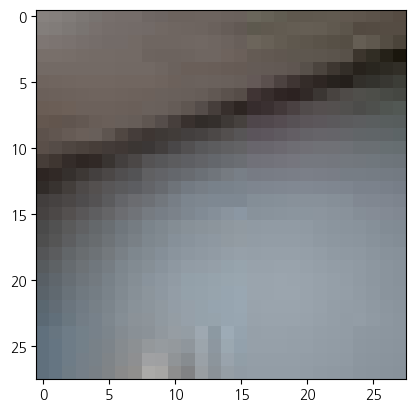

In [ ]:
# 변형된 데이터 불러와서 확인하기

import matplotlib.pyplot as plt

plt.imshow(x_train[800])
print('라벨: ', y_train[800])

### 모델 재학습 (기존 모델 그대로 활용)

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 학습
history = model.fit(x_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
86/86 [==============================] - 1s 8ms/step - loss: 0.7829 - accuracy: 0.8269 - val_loss: 6.4418 - val_accuracy: 0.1818
Epoch 2/10
86/86 [==============================] - 1s 6ms/step - loss: 0.0509 - accuracy: 0.9809 - val_loss: 7.2496 - val_accuracy: 0.2419
Epoch 3/10
86/86 [==============================] - 1s 6ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 8.1398 - val_accuracy: 0.2199
Epoch 4/10
86/86 [==============================] - 1s 6ms/step - loss: 0.0033 - accuracy: 0.9993 - val_loss: 8.1909 - val_accuracy: 0.2610
Epoch 5/10
86/86 [==============================] - 1s 6ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 8.5908 - val_accuracy: 0.2639
Epoch 6/10
86/86 [==============================] - 1s 6ms/step - loss: 6.0798e-04 - accuracy: 1.0000 - val_loss: 9.3723 - val_accuracy: 0.2581
Epoch 7/10
86/86 [==============================] - 1s 6ms/step - loss: 3.8425e-04 - accuracy: 1.0000 - val_loss: 9.6463 - val_accuracy: 0.2639
Epoch 8/10
8

### 테스트 결과 확인

In [ ]:
# x_test_reshaped는 테스트 데이터이고, y_test는 데이터의 실제 레이블입니다
# verbose=2는 평가 과정을 자세히 표시합니다
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)

# 테스트 손실(test_loss)과 테스트 정확도(test_accuracy)를 출력합니다
print(f"테스트 손실: {test_loss}")
print(f"테스트 정확도: {test_accuracy}")

10/10 - 0s - loss: 2.4012 - accuracy: 0.5800 - 37ms/epoch - 4ms/step
테스트 손실: 2.4012069702148438
테스트 정확도: 0.5799999833106995


### 결과 확인 밑 추가 조치 계획

- 900개의 데이터만을 학습했을 때보다는 약 30%정도의 정확도 향상을 했습니다.
- 이제 처음 계획에서 구상했던 2번째 개선방향인 학습률 조정을 통해 모델 성능 향상을 시도해보겠습니다.

In [ ]:
from tensorflow.keras.optimizers import Adam

# 더 큰 학습률로 Adam 옵티마이저 생성
custom_optimizer = Adam(learning_rate=0.01)

# 모델 컴파일 시 사용할 옵티마이저 설정
model.compile(optimizer=custom_optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# x_test_reshaped는 테스트 데이터이고, y_test는 데이터의 실제 레이블입니다
# verbose=2는 평가 과정을 자세히 표시합니다
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)

# 테스트 손실(test_loss)과 테스트 정확도(test_accuracy)를 출력합니다
print(f"테스트 손실: {test_loss}")
print(f"테스트 정확도: {test_accuracy}")

10/10 - 0s - loss: 2.4012 - accuracy: 0.5800 - 127ms/epoch - 13ms/step
테스트 손실: 2.4012069702148438
테스트 정확도: 0.5799999833106995


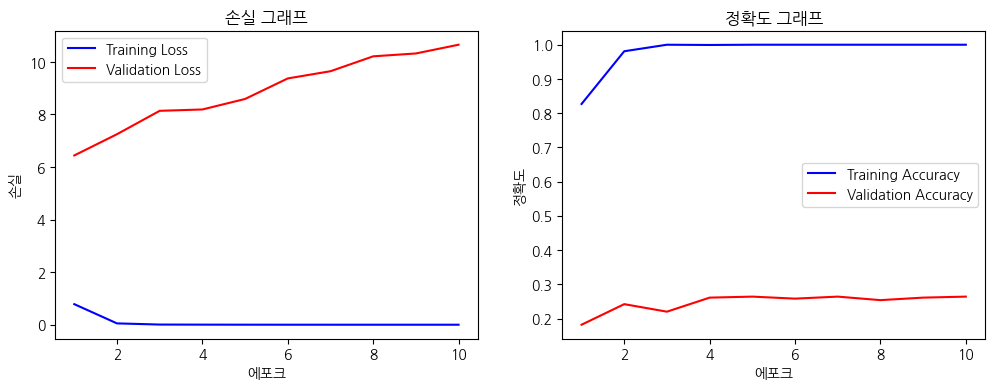

In [ ]:
# 손실(loss)과 정확도(accuracy) 히스토리 가져오기
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# 에포크 수 가져오기
epochs = range(1, len(train_loss) + 1)

# 손실 그래프
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('손실 그래프')
plt.xlabel('에포크')
plt.ylabel('손실')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('정확도 그래프')
plt.xlabel('에포크')
plt.ylabel('정확도')
plt.legend()

plt.show()

- 학습손실은 감소하고 있긴 하지만, 검증 손실은 증가하는 경향입니다.
- 모델이 과적합 되고 있는 것으로 보입니다.
- 이번에는 드롭아웃을 통해 과적합을 방지해 보겠습니다.

## 드롭아웃

- 드롭아웃을 위해서는 네트워크 구조를 수정해야 합니다.
- 드롭아웃은 특히 복잡하거나 학습데이터가 부족한 경우에 유용합니다.
- 맥스 풀링한 이후, 완전 연결층 이후 드롭아웃 레이어를 추가해 구현해 보겠습니다.

### 네트워크 재구성

In [ ]:
# 모델 생성
model = keras.models.Sequential()

# 첫 번째 컨볼루션 층 추가
model.add(keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 3)))

# 첫 번째 맥스 풀링 층 추가
model.add(keras.layers.MaxPooling2D(2, 2))

# 첫 번째 드롭아웃 레이어 추가
model.add(keras.layers.Dropout(0.25))  # 드롭아웃 비율 25%

# 두 번째 컨볼루션 층 추가
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))

# 두 번째 맥스 풀링 층 추가
model.add(keras.layers.MaxPooling2D(2, 2))

# 두 번째 드롭아웃 레이어 추가
model.add(keras.layers.Dropout(0.25))  # 드롭아웃 비율 25%

# 데이터 평탄화 층 추가
model.add(keras.layers.Flatten())

# 완전 연결 (Dense) 층 추가
model.add(keras.layers.Dense(64, activation='relu'))

# 세 번째 드롭아웃 레이어 추가
model.add(keras.layers.Dropout(0.5))   # 드롭아웃 비율 50%

# 출력 층 추가 (클래스가 3개임을 고려)
model.add(keras.layers.Dense(3, activation='softmax'))

# 모델 요약 출력
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 16)        448       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 16)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 13, 13, 16)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 5, 5, 32)          0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 32)         

### 모델 재학습

- 동일한 학습률로 모델을 재학습하고 테스트 하겠습니다.

In [ ]:
custom_optimizer = Adam(learning_rate=0.01)

# 모델 컴파일 시 사용할 옵티마이저 설정
model.compile(optimizer=custom_optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 학습
history = model.fit(x_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
86/86 [==============================] - 1s 8ms/step - loss: 6.7168 - accuracy: 0.4237 - val_loss: 1.8680 - val_accuracy: 0.0000e+00
Epoch 2/10
86/86 [==============================] - 1s 8ms/step - loss: 1.0155 - accuracy: 0.4244 - val_loss: 1.9173 - val_accuracy: 0.0000e+00
Epoch 3/10
86/86 [==============================] - 1s 8ms/step - loss: 1.0165 - accuracy: 0.4142 - val_loss: 1.8748 - val_accuracy: 0.0000e+00
Epoch 4/10
86/86 [==============================] - 1s 7ms/step - loss: 1.0161 - accuracy: 0.4248 - val_loss: 1.9018 - val_accuracy: 0.0000e+00
Epoch 5/10
86/86 [==============================] - 1s 7ms/step - loss: 1.0142 - accuracy: 0.4329 - val_loss: 1.8726 - val_accuracy: 0.0000e+00
Epoch 6/10
86/86 [==============================] - 1s 8ms/step - loss: 1.0152 - accuracy: 0.4354 - val_loss: 1.8832 - val_accuracy: 0.0000e+00
Epoch 7/10
86/86 [==============================] - 1s 8ms/step - loss: 1.0135 - accuracy: 0.4332 - val_loss: 1.9196 - val_accuracy: 0.0

In [ ]:
# x_test_reshaped는 테스트 데이터이고, y_test는 데이터의 실제 레이블입니다
# verbose=2는 평가 과정을 자세히 표시합니다
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)

# 테스트 손실(test_loss)과 테스트 정확도(test_accuracy)를 출력합니다
print(f"테스트 손실: {test_loss}")
print(f"테스트 정확도: {test_accuracy}")

10/10 - 0s - loss: 1.1995 - accuracy: 0.3333 - 42ms/epoch - 4ms/step
테스트 손실: 1.1994776725769043
테스트 정확도: 0.3333333432674408


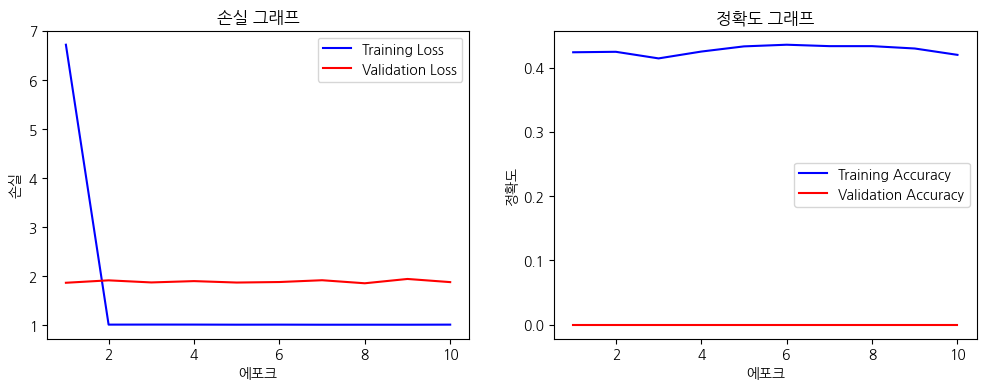

In [ ]:
# 손실(loss)과 정확도(accuracy) 히스토리 가져오기
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# 에포크 수 가져오기
epochs = range(1, len(train_loss) + 1)

# 손실 그래프
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('손실 그래프')
plt.xlabel('에포크')
plt.ylabel('손실')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('정확도 그래프')
plt.xlabel('에포크')
plt.ylabel('정확도')
plt.legend()

plt.show()

- 오히려 모델의 정확도가 감소하는 결과를 보여주고 있습니다.
- 학습률을 재조정하여 다시 테스트 해보겠습니다.

In [ ]:
def create_custom_model():
    model = keras.models.Sequential()

    # 첫 번째 컨볼루션 층
    model.add(keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 3)))
    model.add(keras.layers.MaxPooling2D(2, 2))
    model.add(keras.layers.Dropout(0.25))

    # 두 번째 컨볼루션 층
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D(2, 2))
    model.add(keras.layers.Dropout(0.25))

    # 데이터 평탄화 층
    model.add(keras.layers.Flatten())

    # 완전 연결 (Dense) 층
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.5))

    # 출력 층
    model.add(keras.layers.Dense(3, activation='softmax'))

    return model

# 함수로 정의한 모델 생성
custom_model = create_custom_model()

# 모델 요약 출력
custom_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 16)        448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 13, 13, 16)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 13, 13, 16)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 5, 5, 32)          0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 5, 5, 32)         

In [ ]:
custom_optimizer = Adam(learning_rate=0.01)

# 모델 컴파일 시 사용할 옵티마이저 설정
model.compile(optimizer=custom_optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 학습
history = model.fit(x_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
86/86 [==============================] - 1s 9ms/step - loss: 1.0143 - accuracy: 0.4362 - val_loss: 1.8585 - val_accuracy: 0.0000e+00
Epoch 2/10
86/86 [==============================] - 1s 7ms/step - loss: 1.0136 - accuracy: 0.4285 - val_loss: 1.8436 - val_accuracy: 0.0000e+00
Epoch 3/10
86/86 [==============================] - 1s 7ms/step - loss: 1.0138 - accuracy: 0.4266 - val_loss: 1.8935 - val_accuracy: 0.0000e+00
Epoch 4/10
86/86 [==============================] - 1s 7ms/step - loss: 1.0137 - accuracy: 0.4296 - val_loss: 1.8493 - val_accuracy: 0.0000e+00
Epoch 5/10
86/86 [==============================] - 1s 7ms/step - loss: 1.0733 - accuracy: 0.4189 - val_loss: 1.8800 - val_accuracy: 0.0000e+00
Epoch 6/10
86/86 [==============================] - 1s 7ms/step - loss: 1.0143 - accuracy: 0.4197 - val_loss: 1.8893 - val_accuracy: 0.0000e+00
Epoch 7/10
86/86 [==============================] - 1s 7ms/step - loss: 1.0137 - accuracy: 0.4208 - val_loss: 1.9285 - val_accuracy: 0.0

In [ ]:
# x_test_reshaped는 테스트 데이터이고, y_test는 데이터의 실제 레이블입니다
# verbose=2는 평가 과정을 자세히 표시합니다
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)

# 테스트 손실(test_loss)과 테스트 정확도(test_accuracy)를 출력합니다
print(f"테스트 손실: {test_loss}")
print(f"테스트 정확도: {test_accuracy}")

10/10 - 0s - loss: 1.2007 - accuracy: 0.3333 - 43ms/epoch - 4ms/step
테스트 손실: 1.2007153034210205
테스트 정확도: 0.3333333432674408


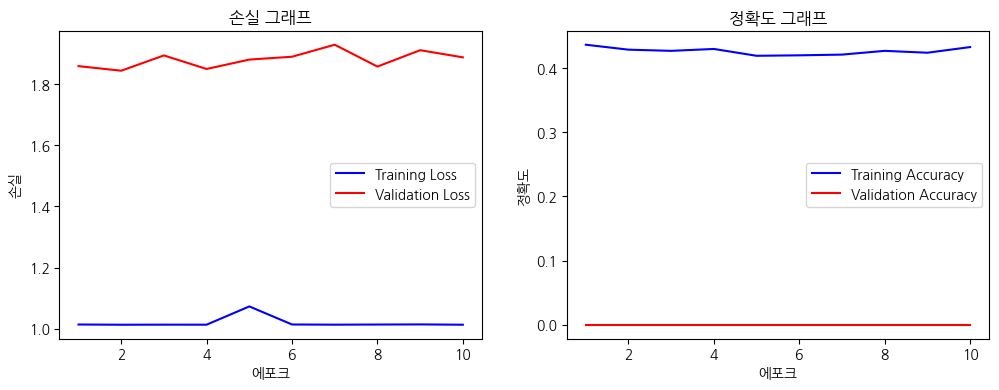

In [ ]:
# 손실(loss)과 정확도(accuracy) 히스토리 가져오기
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# 에포크 수 가져오기
epochs = range(1, len(train_loss) + 1)

# 손실 그래프
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('손실 그래프')
plt.xlabel('에포크')
plt.ylabel('손실')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('정확도 그래프')
plt.xlabel('에포크')
plt.ylabel('정확도')
plt.legend()

plt.show()

- 학습률의 조정으로는 모델 성능이 크게 변하지 않는 것을 알 수 있습니다.
- 드롭아웃을 하면 학습과정이 느려지는데 이로 인해 epoch의 수가 다소 부족했을 수 있습니다. epoch를 20으로 늘려서 재학습 시켜 보겠습니다.

In [ ]:
# 함수로 정의한 모델 생성
custom_model = create_custom_model()

# 모델 요약 출력
custom_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 13, 13, 16)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 13, 13, 16)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 5, 5, 32)          0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 5, 5, 32)         

In [ ]:
custom_optimizer = Adam(learning_rate=0.01)

# 모델 컴파일 시 사용할 옵티마이저 설정
model.compile(optimizer=custom_optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 학습
history = model.fit(x_train, y_train, epochs=20, validation_split=0.2)

Epoch 1/20
86/86 [==============================] - 1s 8ms/step - loss: 1.0140 - accuracy: 0.4244 - val_loss: 1.8844 - val_accuracy: 0.0000e+00
Epoch 2/20
86/86 [==============================] - 1s 7ms/step - loss: 1.0136 - accuracy: 0.4211 - val_loss: 1.8561 - val_accuracy: 0.0000e+00
Epoch 3/20
86/86 [==============================] - 1s 8ms/step - loss: 1.0137 - accuracy: 0.4178 - val_loss: 1.9201 - val_accuracy: 0.0000e+00
Epoch 4/20
86/86 [==============================] - 1s 8ms/step - loss: 1.0130 - accuracy: 0.4439 - val_loss: 1.9032 - val_accuracy: 0.0000e+00
Epoch 5/20
86/86 [==============================] - 1s 8ms/step - loss: 1.0140 - accuracy: 0.4288 - val_loss: 1.8945 - val_accuracy: 0.0000e+00
Epoch 6/20
86/86 [==============================] - 1s 8ms/step - loss: 1.0146 - accuracy: 0.4248 - val_loss: 1.8382 - val_accuracy: 0.0000e+00
Epoch 7/20
86/86 [==============================] - 1s 8ms/step - loss: 1.0133 - accuracy: 0.4453 - val_loss: 1.9131 - val_accuracy: 0.0

In [ ]:
# x_test_reshaped는 테스트 데이터이고, y_test는 데이터의 실제 레이블입니다
# verbose=2는 평가 과정을 자세히 표시합니다
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)

# 테스트 손실(test_loss)과 테스트 정확도(test_accuracy)를 출력합니다
print(f"테스트 손실: {test_loss}")
print(f"테스트 정확도: {test_accuracy}")

10/10 - 0s - loss: 1.1978 - accuracy: 0.3333 - 44ms/epoch - 4ms/step
테스트 손실: 1.197798728942871
테스트 정확도: 0.3333333432674408


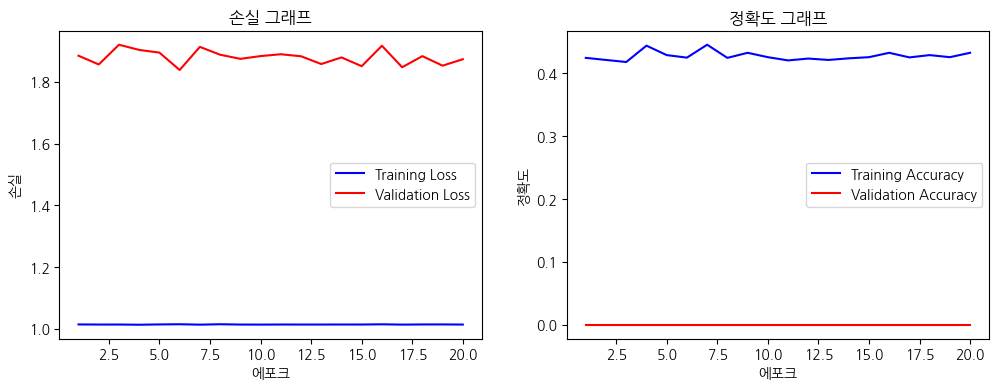

In [ ]:
# 손실(loss)과 정확도(accuracy) 히스토리 가져오기
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# 에포크 수 가져오기
epochs = range(1, len(train_loss) + 1)

# 손실 그래프
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('손실 그래프')
plt.xlabel('에포크')
plt.ylabel('손실')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('정확도 그래프')
plt.xlabel('에포크')
plt.ylabel('정확도')
plt.legend()

plt.show()

- 여러가지 시도를 해보았으나 유효한 효과를 얻지는 못했습니다.
- 다음 방법인 데이터 증강을 시도해보겠습니다.

## 데이터 증강

---

# Closing
---
---

## 🚦 Summary
- 가위, 바위, 보 이미지를 학습해서 분류하는 모델을 생성해보았습니다.
- 기본적으로 데이터가 적을때는 33%정도의 성능을 보였으나 추가데이터를 4배정도 증가시켰을때 66%정도로 성능이 향상도니 모습을 보였습니다.
- 그외에 드롭아웃이나 학습률 조정을 시도했지만 유의미한 결과를 얻지 못했습니다.
- 시간부족으로 데이터 증강이나 베이지안 최적화등도 시도하지 못햇습니다.
- 차후에 시간을 내어 이부분에 대한 수정 및 성능 개선을 시도해보겠습니다.

---
## 회고


### KEEP
- 학습하며 이해했던 개념들을 바탕으로 최적화를 하기 위해 노력했다.
- 단순 정확도를 높이기 위한 시도가 아니라, 각 방법들을 찾아보고 적용하려 했다.


### PROBLEM
- 의외로 파일 전처리하는 코드에서 애먹어서 오래걸렸다.
    - 이미지 resizing할때 기존에 resize한 이미지를 고려하지 못한점(예외처리추가함)
    - unzip하고 파일 옮기고, 파일명 변경하는 코드 작성 등


### TRY
- os관련 모듈이나 데이터 이동, 관리 같은 로직에 대한 코드 이해가 부족했다. 이 부분을 채우기 위한 공부를 해보자.
    - 불러온 데이터에 대한 전처리가 아닌, 불러오고 관리하는 과정에서의 처리 방법

## Ref.

- [Teachable Machine을 활용한 데이터 생성](https://teachablemachine.withgoogle.com/)
- [Tensorflow MNIST Dataset](https://www.tensorflow.org/datasets/catalog/mnist?hl=ko)
- [Matplotlib 활용사례](https://matplotlib.org/cheatsheets/)
- [Train / Test / Validation 데이터셋의 차이](https://ganghee-lee.tistory.com/38)
- [교차검증(Cross-validation) 필요성 및 장단점](https://heytech.tistory.com/113)
- [이미지데이터의 차원을 변형해주는 reshape](https://supermemi.tistory.com/entry/Python-3-Numpy-reshape-%ED%95%A8%EC%88%98%EB%9E%80)
- [Bayesian Optimization for Neural Architecture Search](https://wikidocs.net/195717)
- [Rock-Paper-Scissors Image Classification Using CNN](https://medium.com/geekculture/rock-paper-scissors-image-classification-using-cnn-eefe4569b415)